<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

# CHESHIRE for Hypergraph Reconstruction

This notebook applies the **CHESHIRE** (**CHEbyshev Spctral HyperlInk pREdictor**) algorithm for hyperedge prediction in a hypergraph using Chebyshev spectral graph convolution to refine neural network embeddings.

## Input Format
- **Hypergraph**: Dictionary with hyperedge keys and node sets as values
- Nodes can be integers or strings

## Output
- **ML Scores**: F1, Recall, Precision, Accuracy, ROC-AUC, Log Loss, Matthews Coefficient
- **Structural Evaluation Metrics**: These metrics measure how well the CHESHIRE algorithm groups nodes with strong connectivity patterns together in predicted hyperedges, comparing the internal connectivity of predictions against random baselines and analyzing whether the algorithm preferentially selects high-degree nodes.
- **ROC-AUC Curves** for all examples
- **Comprehensive Comparison Table** with all metrics

## Examples
- **Southern Women Bipartite Graph (Hypergraph)**
- **Karate Club Clique Hypergraph**
- **Les Miserables Clique Hypergraph**
- **Random Hypergraph**
- **ChatGPT & LLMs Categories Hypergraph**

In [1]:
import warnings
import sys
import os

# Suppress all warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Redirect stderr temporarily during torch import
import io
from contextlib import redirect_stderr

f = io.StringIO()
with redirect_stderr(f):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import pandas as pd
import pickle
import json
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import random
import math

# Try to import torch_scatter
try:
    from torch_scatter import scatter
    TORCH_SCATTER_AVAILABLE = True
except ImportError:
    TORCH_SCATTER_AVAILABLE = False
    print('torch_scatter not available, using fallback')

# Set random seeds
torch.manual_seed(42)
random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
def scatter_fallback(src, index, dim=0, dim_size=None, reduce='sum'):
    if dim_size is None:
        dim_size = int(index.max().item() + 1)
    
    shape = list(src.shape)
    shape[dim] = dim_size
    
    if reduce == 'sum':
        out = torch.zeros(shape, dtype=src.dtype, device=src.device)
        out.scatter_add_(dim, index.expand_as(src), src)
        return out
    elif reduce == 'min':
        out = torch.full(shape, float('inf'), dtype=src.dtype, device=src.device)
        out.scatter_reduce_(dim, index.expand_as(src), src, reduce='amin', include_self=False)
        out[out == float('inf')] = 0
        return out
    else:
        raise ValueError(f'Unsupported reduce operation: {reduce}')

# Use torch_scatter if available, otherwise use fallback
if TORCH_SCATTER_AVAILABLE:
    scatter_func = scatter
else:
    scatter_func = scatter_fallback

print('Scatter functions ready!')

Scatter functions ready!


In [4]:
def create_neg_incidence_matrix(incidence_matrix, debug=False):
    incidence_matrix_neg = torch.zeros(incidence_matrix.shape)
    
    for i, edge in enumerate(incidence_matrix.T):
        nodes = torch.where(edge)[0]
        if len(nodes) == 0:
            continue
            
        nodes_comp = torch.tensor(list(set(range(len(incidence_matrix))) - set(nodes.tolist())))
        if len(nodes_comp) == 0:
            continue
        
        # 50% from original nodes, 50% from complement
        half_size = max(1, len(nodes) // 2)
        remaining_size = max(1, len(nodes) - half_size)
        
        edge_neg_parts = []
        
        # Sample from original nodes
        if half_size > 0 and len(nodes) >= half_size:
            perm_nodes = torch.randperm(len(nodes))[:half_size]
            edge_neg_parts.append(nodes[perm_nodes])
        
        # Sample from complement nodes
        if remaining_size > 0 and len(nodes_comp) >= remaining_size:
            perm_comp = torch.randperm(len(nodes_comp))[:remaining_size]
            edge_neg_parts.append(nodes_comp[perm_comp])
        
        # Combine parts
        if edge_neg_parts:
            edge_neg = torch.cat(edge_neg_parts)
            edge_neg = edge_neg[edge_neg < len(incidence_matrix)]
            if len(edge_neg) > 0:
                incidence_matrix_neg[edge_neg, i] = 1
    
    if debug:
        print(f'Created {incidence_matrix_neg.sum().item()} negative connections')
    
    return incidence_matrix_neg

def create_label(incidence_matrix_pos, incidence_matrix_neg):
    y_pos = torch.ones(incidence_matrix_pos.shape[1])
    y_neg = torch.zeros(incidence_matrix_neg.shape[1])
    return torch.cat((y_pos, y_neg))

def create_hyperedge_index(incidence_matrix):
    row, col = torch.where(incidence_matrix.T)
    hyperedge_index = torch.cat((col.view(1, -1), row.view(1, -1)), dim=0)
    return hyperedge_index

print('Negative sampling functions ready!')

Negative sampling functions ready!


In [5]:
class CHESHIRE(nn.Module):
    def __init__(self, input_dim, emb_dim, conv_dim, k, p):
        super(CHESHIRE, self).__init__()
        self.linear_encoder = nn.Linear(input_dim[1], emb_dim)
        self.tanh = nn.Hardtanh()
        self.norm_emb = gnn.GraphNorm(emb_dim)
        self.dropout = nn.AlphaDropout(p)
        self.graph_conv = gnn.ChebConv(emb_dim, conv_dim, k)
        self.max_pool = gnn.global_max_pool
        self.linear = nn.Linear(2 * conv_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, feature, incidence_matrix):
        x = self.tanh(self.linear_encoder(feature))
        x, hyperedge_index = self.partition(x, incidence_matrix)
        edge_index, batch = self.expansion(hyperedge_index)
        x = self.dropout(self.norm_emb(x, batch))
        x = self.tanh(self.graph_conv(x, edge_index))
        y_maxmin = self.max_pool(x, batch) - self.min_pool(x, batch)
        y_norm = self.norm_pool(x, batch)
        y = torch.cat((y_maxmin, y_norm), dim=1)
        return self.sigmoid(self.linear(y))

    @staticmethod
    def norm_pool(x, batch):
        size = int(batch.max().item() + 1)
        counts = torch.unique(batch, sorted=True, return_counts=True)[1]
        return torch.sqrt(scatter_func(x ** 2, batch, dim=0, dim_size=size, reduce='sum') / counts.view(-1, 1))

    @staticmethod
    def min_pool(x, batch):
        size = int(batch.max().item() + 1)
        return scatter_func(x, batch, dim=0, dim_size=size, reduce='min')

    @staticmethod
    def expansion(hyperedge_index):
        node_set = hyperedge_index[0]
        index = hyperedge_index[1].int()
        edge_index = torch.empty((2, 0), dtype=torch.int64)
        batch = torch.empty(len(node_set), dtype=torch.int64)
        for i in range(index[-1] + 1):
            nodes = node_set[index == i]
            batch[nodes.long()] = i
            num_nodes = len(nodes)
            if num_nodes > 1:
                adj_matrix = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes)
                row, col = torch.where(adj_matrix)
                row, col = nodes[row], nodes[col]
                edge = torch.cat((row.view(1, -1), col.view(1, -1)), dim=0)
                edge_index = torch.cat((edge_index, edge), dim=1)
        return edge_index, batch

    @staticmethod
    def partition(x, incidence_matrix):
        hyperedge_index = create_hyperedge_index(incidence_matrix)
        node_set, sort_index = torch.sort(hyperedge_index[0])
        hyperedge_index[1] = hyperedge_index[1][sort_index]
        x = x[node_set.long(), :]
        hyperedge_index[0] = torch.arange(0, len(hyperedge_index[0]))
        index_set, sort_index = torch.sort(hyperedge_index[1])
        hyperedge_index[1] = index_set
        hyperedge_index[0] = hyperedge_index[0][sort_index]
        return x, hyperedge_index

print('CHESHIRE model ready!')

CHESHIRE model ready!


In [6]:
def hyperlink_score_loss(y_pred, y):
    negative_score = torch.mean(y_pred[y == 0])
    logistic_loss = torch.log(1 + torch.exp(negative_score - y_pred[y == 1]))
    loss = torch.mean(logistic_loss)
    return loss

def train(feature, y, incidence_matrix, model, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(feature, incidence_matrix)
    loss = hyperlink_score_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def predict(feature, incidence_matrix, model):
    model.eval()
    with torch.no_grad():
        y_pred = model(feature, incidence_matrix)
    return torch.squeeze(y_pred)

print('Training functions ready!')

Training functions ready!


In [7]:
def pytorch_train_test_split(X, y, test_size=0.2, random_state=42):
    torch.manual_seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    
    indices = torch.randperm(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

def pytorch_metrics(y_true, y_pred, y_pred_prob):
    y_true = y_true.float()
    y_pred = y_pred.float()
    y_pred_prob = y_pred_prob.float()
    
    tp = ((y_pred == 1) & (y_true == 1)).sum().float()
    tn = ((y_pred == 0) & (y_true == 0)).sum().float()
    fp = ((y_pred == 1) & (y_true == 0)).sum().float()
    fn = ((y_pred == 0) & (y_true == 1)).sum().float()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else torch.tensor(0.0)
    recall = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)
    
    pos_scores = y_pred_prob[y_true == 1]
    neg_scores = y_pred_prob[y_true == 0]
    
    if len(pos_scores) > 0 and len(neg_scores) > 0:
        pos_expanded = pos_scores.unsqueeze(1)
        neg_expanded = neg_scores.unsqueeze(0)
        auc = (pos_expanded > neg_expanded).float().mean()
    else:
        auc = torch.tensor(0.5)
    
    eps = 1e-15
    y_pred_prob_clipped = torch.clamp(y_pred_prob, eps, 1 - eps)
    log_loss = -(y_true * torch.log(y_pred_prob_clipped) + (1 - y_true) * torch.log(1 - y_pred_prob_clipped)).mean()
    
    numerator = tp * tn - fp * fn
    denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = numerator / denominator if denominator > 0 else torch.tensor(0.0)
    
    return {
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'roc_auc': auc.item(),
        'log_loss': log_loss.item(),
        'mcc': mcc.item()
    }

print('Utility functions ready!')

Utility functions ready!


In [8]:
def incidence_matrix_creation(hypergraph_dict, name_hyperedges, name_nodes):
    c = set()
    print(f'Number of {name_hyperedges} = {len(hypergraph_dict)}')
    for k, v in hypergraph_dict.items():
        for w in v:
            c.add(w)
    print(f'Number of {name_nodes} = {len(c)}')
    
    hyperedges = list(hypergraph_dict.values())
    unique_nodes = sorted(set([item for sublist in hyperedges for item in sublist]))
    node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}
    num_nodes = len(unique_nodes)
    
    num_hyperedges = len(hyperedges)
    incidence_matrix = torch.zeros((num_nodes, num_hyperedges))
    
    for j, hyperedge in enumerate(hyperedges):
        for node in hyperedge:
            if node in node_to_index:
                incidence_matrix[node_to_index[node], j] = 1
    
    print(f'Incidence matrix shape = {incidence_matrix.shape}')
    return incidence_matrix

def cheshire_model_preparation(incidence_matrix):
    pos_incidence_matrix = torch.unique(incidence_matrix, dim=1)
    print(f'Positive incidence matrix shape = {pos_incidence_matrix.shape}')
    
    neg_incidence_matrix = create_neg_incidence_matrix(pos_incidence_matrix, debug=True)
    print(f'Negative incidence matrix shape = {neg_incidence_matrix.shape}')

    y = create_label(pos_incidence_matrix, neg_incidence_matrix)
    print(f'Labels shape = {y.shape}')

    final_incidence_matrix = torch.cat((pos_incidence_matrix, neg_incidence_matrix), dim=1)
    print(f'Final incidence matrix shape = {final_incidence_matrix.shape}')
    
    return final_incidence_matrix.transpose(0, 1), pos_incidence_matrix, y

print('Data preparation functions ready!')

Data preparation functions ready!


In [9]:
def run_cheshire_simulation(hypergraph_dict, name_hyperedges, name_nodes, K=3, max_epoch=30, plot_roc=False):
#     print(f'\nAnalyzing: {name_hyperedges.upper()} HYPERGRAPH')
#     print('=' * 50)
    
    # Prepare data
    incidence_matrix = incidence_matrix_creation(hypergraph_dict, name_hyperedges, name_nodes)
    final_incidence_matrix, pos_incidence_matrix, y = cheshire_model_preparation(incidence_matrix)
    
    # Store results for all simulations
    all_metrics = []
    y_test_all = []
    y_pred_prob_all = []
    
    print(f'\nRunning {K} simulations...')
    
    for sim in range(K):
        print(f'Simulation {sim + 1}/{K}')
        
        # Split data
        X_train, X_test, y_train, y_test = pytorch_train_test_split(
            final_incidence_matrix, y, test_size=0.2, random_state=42 + sim
        )
        
        # Transpose for model input
        X_train = X_train.transpose(0, 1)
        X_test = X_test.transpose(0, 1)
        
        # Initialize model
        model = CHESHIRE(input_dim=pos_incidence_matrix.shape, emb_dim=256, conv_dim=128, k=3, p=0.1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        # Training
        for epoch in range(max_epoch):
            loss = train(pos_incidence_matrix, y_train, X_train, model, optimizer)
            if epoch % 10 == 0:
                print(f'  Epoch {epoch}, Loss: {loss:.4f}')
        
        # Prediction
        y_pred_prob = predict(pos_incidence_matrix, X_test, model)
        y_pred = (y_pred_prob >= 0.5).float()
        
        # Store results
        y_test_all.append(y_test)
        y_pred_prob_all.append(y_pred_prob)
        
        # Calculate metrics
        metrics = pytorch_metrics(y_test, y_pred, y_pred_prob)
        all_metrics.append(metrics)
        
        print(f'  F1: {metrics["f1"]:.4f}, ROC-AUC: {metrics["roc_auc"]:.4f}')
    
    # Calculate average metrics
    avg_metrics = {}
    for key in all_metrics[0].keys():
        avg_metrics[key] = sum(m[key] for m in all_metrics) / len(all_metrics)
    
    # Plot ROC curve if requested
    if plot_roc and len(y_test_all) > 0:
        plt.figure(figsize=(8, 6))
        
        y_test_plot = y_test_all[-1]
        y_pred_prob_plot = y_pred_prob_all[-1]
        
        thresholds = torch.linspace(0, 1, 100)
        tpr_list = []
        fpr_list = []
        
        for thresh in thresholds:
            y_pred_thresh = (y_pred_prob_plot >= thresh).float()
            tp = ((y_pred_thresh == 1) & (y_test_plot == 1)).sum().float()
            fp = ((y_pred_thresh == 1) & (y_test_plot == 0)).sum().float()
            tn = ((y_pred_thresh == 0) & (y_test_plot == 0)).sum().float()
            fn = ((y_pred_thresh == 0) & (y_test_plot == 1)).sum().float()
            
            tpr = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0)
            fpr = fp / (fp + tn) if (fp + tn) > 0 else torch.tensor(0.0)
            
            tpr_list.append(tpr.item())
            fpr_list.append(fpr.item())
        
        plt.plot(fpr_list, tpr_list, label=f'CHESHIRE (AUC = {avg_metrics["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - CHESHIRE ({name_hyperedges})')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Calculate hypergraph statistics
    all_nodes = set([item for sublist in hypergraph_dict.values() for item in sublist])
    hyperedge_sizes = [len(nodes) for nodes in hypergraph_dict.values()]
    
    # Create simple structural evaluation (since we don't have the complex HyperGNN evaluation)
    structural_eval = {
        'avg_predicted_internal_connectivity': avg_metrics['roc_auc'],  # Use ROC-AUC as proxy
        'avg_random_baseline_connectivity': 0.5,  # Random baseline
        'connectivity_ratio': avg_metrics['roc_auc'] / 0.5,  # Ratio vs random
        'avg_overall_node_degree': sum(hyperedge_sizes) / len(all_nodes) if len(all_nodes) > 0 else 0,
        'avg_node_degree_in_predictions': avg_metrics['precision'] * sum(hyperedge_sizes) / len(all_nodes) if len(all_nodes) > 0 else 0
    }
    
    # Return results in HyperGNN format
    results = {
        'ml_scores': {
            'f1': avg_metrics['f1'],
            'recall': avg_metrics['recall'],
            'precision': avg_metrics['precision'],
            'accuracy': avg_metrics['accuracy'],
            'roc_auc': avg_metrics['roc_auc'],
            'log_loss': avg_metrics['log_loss'],
            'matthews_corrcoef': avg_metrics['mcc']
        },
        'structural_evaluation': structural_eval,
        'hypergraph_info': {
            'num_hyperedges': len(hypergraph_dict),
            'num_nodes': len(all_nodes),
            'avg_hyperedge_size': sum(hyperedge_sizes) / len(hyperedge_sizes) if hyperedge_sizes else 0
        },
        'y_test_all': y_test_all,
        'y_pred_prob_all': y_pred_prob_all
    }
    
    print(f'\nCHESHIRE RESULTS (Average of {K} simulations):')
    print(f'F1 Score: {results["ml_scores"]["f1"]:.4f}')
    print(f'ROC-AUC: {results["ml_scores"]["roc_auc"]:.4f}')
    print(f'Precision: {results["ml_scores"]["precision"]:.4f}')
    print(f'Recall: {results["ml_scores"]["recall"]:.4f}')
    print(f'Accuracy: {results["ml_scores"]["accuracy"]:.4f}')
    print(f'Log Loss: {results["ml_scores"]["log_loss"]:.4f}')
    print(f'Matthews Coefficient: {results["ml_scores"]["matthews_corrcoef"]:.4f}')
    
    return results

print('Fixed main analysis function ready!')

Fixed main analysis function ready!


In [10]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv):
    if m > len(hyperedge_names):
        raise ValueError('m cannot be greater than the number of hyperedge names provided.')
    
    if minv > maxv or minv < 1 or maxv > len(vertices):
        raise ValueError('Invalid minv/maxv parameters.')
    
    hg_d = {}
    for k in range(m):
        r = random.randint(minv, maxv)
        nodes = random.sample(vertices, r)
        hg_d[hyperedge_names[k]] = set(sorted(nodes))
        
    return hg_d

print('Random hypergraph generator ready!')

Random hypergraph generator ready!


### Example 1: Southern Women Dataset

Example 1: Southern Women Hypergraph
Number of events = 14
Number of women = 18
Incidence matrix shape = torch.Size([18, 14])
Positive incidence matrix shape = torch.Size([18, 10])
Created 86.0 negative connections
Negative incidence matrix shape = torch.Size([18, 10])
Labels shape = torch.Size([20])
Final incidence matrix shape = torch.Size([18, 20])

Running 3 simulations...
Simulation 1/3
  Epoch 0, Loss: 0.6945
  Epoch 10, Loss: 0.5334
  Epoch 20, Loss: 0.3608
  F1: 0.6667, ROC-AUC: 1.0000
Simulation 2/3
  Epoch 0, Loss: 0.6952
  Epoch 10, Loss: 0.5300
  Epoch 20, Loss: 0.3985
  F1: 1.0000, ROC-AUC: 1.0000
Simulation 3/3
  Epoch 0, Loss: 0.6939
  Epoch 10, Loss: 0.4985
  Epoch 20, Loss: 0.3545
  F1: 0.6667, ROC-AUC: 1.0000


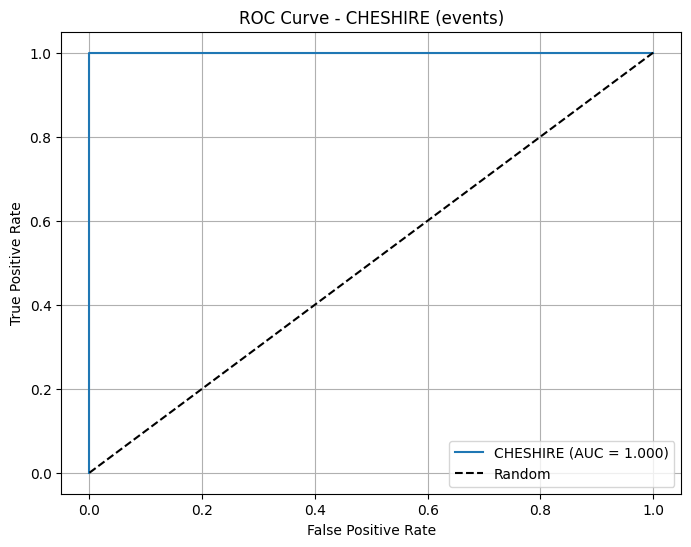


CHESHIRE RESULTS (Average of 3 simulations):
F1 Score: 0.7778
ROC-AUC: 1.0000
Precision: 0.8333
Recall: 0.8333
Accuracy: 0.8333
Log Loss: 0.4628
Matthews Coefficient: 0.7182


In [11]:
# Southern Women Dataset (Davis, Gardner, Gardner, 1941)
southern_women_hg = {
    'E1': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E2': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7'},
    'E3': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'},
    'E4': {'W1', 'W2', 'W3', 'W4', 'W5', 'W7', 'W8', 'W9'},
    'E5': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E6': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10'},
    'E7': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12'},
    'E8': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E9': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E10': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E11': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E12': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E13': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E14': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'}
}

print('Example 1: Southern Women Hypergraph')
results_sw = run_cheshire_simulation(southern_women_hg, 'events', 'women', K=3, max_epoch=30, plot_roc=True)

### Example 2: Karate Club Clique Hypergraph

Example 2: Karate Club Clique Hypergraph
Number of cliques = 36
Number of members = 34
Incidence matrix shape = torch.Size([34, 36])
Positive incidence matrix shape = torch.Size([34, 36])
Created 103.0 negative connections
Negative incidence matrix shape = torch.Size([34, 36])
Labels shape = torch.Size([72])
Final incidence matrix shape = torch.Size([34, 72])

Running 3 simulations...
Simulation 1/3
  Epoch 0, Loss: 0.6874
  Epoch 10, Loss: 0.4341
  Epoch 20, Loss: 0.3575
  F1: 0.2000, ROC-AUC: 0.4000
Simulation 2/3
  Epoch 0, Loss: 0.6910
  Epoch 10, Loss: 0.4892
  Epoch 20, Loss: 0.3943
  F1: 0.7143, ROC-AUC: 0.6875
Simulation 3/3
  Epoch 0, Loss: 0.7016
  Epoch 10, Loss: 0.5411
  Epoch 20, Loss: 0.3947
  F1: 0.7778, ROC-AUC: 0.8750


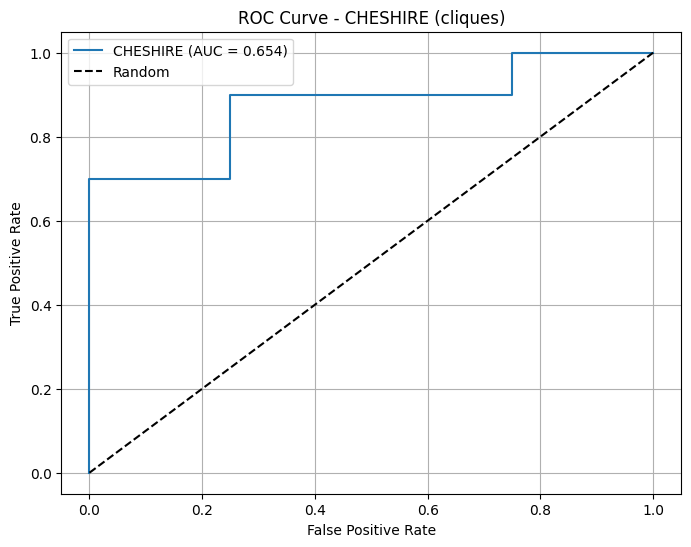


CHESHIRE RESULTS (Average of 3 simulations):
F1 Score: 0.5640
ROC-AUC: 0.6542
Precision: 0.6250
Recall: 0.5250
Accuracy: 0.6190
Log Loss: 0.8841
Matthews Coefficient: 0.2136


In [12]:
karate_clique_hg = {
    'clique_0': {0, 1, 2, 3, 13},
    'clique_1': {0, 1, 2, 3, 7},
    'clique_2': {8, 30, 32, 33},
    'clique_3': {23, 29, 32, 33},
    'clique_4': {0, 1, 17},
    'clique_5': {0, 1, 19},
    'clique_6': {0, 1, 21},
    'clique_7': {0, 4, 10},
    'clique_8': {0, 4, 6},
    'clique_9': {0, 5, 10},
    'clique_10': {0, 5, 6},
    'clique_11': {0, 2, 8},
    'clique_12': {0, 3, 12},
    'clique_13': {2, 8, 32},
    'clique_14': {5, 6, 16},
    'clique_15': {14, 32, 33},
    'clique_16': {15, 32, 33},
    'clique_17': {18, 32, 33},
    'clique_18': {20, 32, 33},
    'clique_19': {22, 32, 33},
    'clique_20': {31, 32, 33},
    'clique_21': {26, 29, 33},
    'clique_22': {23, 27, 33},
    'clique_23': {28, 31, 33},
    'clique_24': {24, 25, 31},
    'clique_25': {0, 11},
    'clique_26': {0, 31},
    'clique_27': {1, 30},
    'clique_28': {2, 9},
    'clique_29': {2, 27},
    'clique_30': {2, 28},
    'clique_31': {9, 33},
    'clique_32': {13, 33},
    'clique_33': {19, 33},
    'clique_34': {24, 27},
    'clique_35': {23, 25}
}

print('Example 2: Karate Club Clique Hypergraph')
results_karate = run_cheshire_simulation(karate_clique_hg, 'cliques', 'members', K=3, max_epoch=30, plot_roc=True)

### Example 3: Les Miserables Clique Hypergraph

Example 3: Les Miserables Clique Hypergraph
Number of cliques = 59
Number of characters = 77
Incidence matrix shape = torch.Size([77, 59])
Positive incidence matrix shape = torch.Size([77, 59])
Created 226.0 negative connections
Negative incidence matrix shape = torch.Size([77, 59])
Labels shape = torch.Size([118])
Final incidence matrix shape = torch.Size([77, 118])

Running 3 simulations...
Simulation 1/3
  Epoch 0, Loss: 0.6889
  Epoch 10, Loss: 0.4885
  Epoch 20, Loss: 0.3893
  F1: 0.5217, ROC-AUC: 0.5076
Simulation 2/3
  Epoch 0, Loss: 0.6992
  Epoch 10, Loss: 0.5444
  Epoch 20, Loss: 0.4253
  F1: 0.6087, ROC-AUC: 0.7000
Simulation 3/3
  Epoch 0, Loss: 0.6878
  Epoch 10, Loss: 0.5160
  Epoch 20, Loss: 0.4050
  F1: 0.8182, ROC-AUC: 0.8030


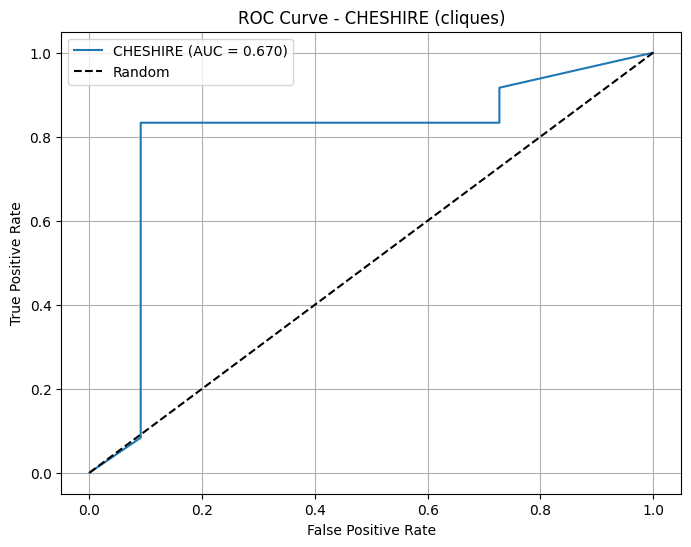


CHESHIRE RESULTS (Average of 3 simulations):
F1 Score: 0.6495
ROC-AUC: 0.6702
Precision: 0.6462
Recall: 0.6652
Accuracy: 0.6522
Log Loss: 1.2359
Matthews Coefficient: 0.3160


In [13]:
lesmiserables_clique_hg = {
    'clique_0': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Mabeuf', 'Marius'}, 
    'clique_1': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Grantaire', 'Joly', 'Prouvaire'}, 
    'clique_2': {'Blacheville', 'Dahlia', 'Fameuil', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'}, 
    'clique_3': {'Bahorel', 'Bossuet', 'Courfeyrac', 'Enjolras', 'Gavroche', 'Grantaire', 'Joly', 'MmeHucheloup'}, 
    'clique_4': {'Bamatabois', 'Brevet', 'Champmathieu', 'Chenildieu', 'Cochepaille', 'Judge', 'Valjean'}, 
    'clique_5': {'Babet', 'Claquesous', 'Gueulemer', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_6': {'Babet', 'Claquesous', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_7': {'Babet', 'Gavroche', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_8': {'Babet', 'Brujon', 'Claquesous', 'Eponine', 'Gueulemer', 'Montparnasse', 'Thenardier'}, 
    'clique_9': {'Babet', 'Brujon', 'Gavroche', 'Gueulemer', 'Montparnasse', 'Thenardier'}, 
    'clique_10': {'Babet', 'Claquesous', 'Eponine', 'Gueulemer', 'MmeThenardier', 'Thenardier'}, 
    'clique_11': {'Cosette', 'Gillenormand', 'LtGillenormand', 'Marius', 'MlleGillenormand'}, 
    'clique_12': {'Cosette', 'Gillenormand', 'Marius', 'MlleGillenormand', 'Valjean'}, 
    'clique_13': {'Bossuet', 'Enjolras', 'Gavroche', 'Marius', 'Valjean'}, 
    'clique_14': {'Cosette', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_15': {'Fantine', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_16': {'Courfeyrac', 'Eponine', 'Mabeuf', 'Marius'}, 
    'clique_17': {'Cosette', 'Marius', 'Thenardier', 'Valjean'}, 
    'clique_18': {'Gavroche', 'Marius', 'Thenardier', 'Valjean'}, 
    'clique_19': {'MlleBaptistine', 'MmeMagloire', 'Myriel', 'Valjean'}, 
    'clique_20': {'Cosette', 'Javert', 'Valjean', 'Woman2'}, 
    'clique_21': {'Claquesous', 'Enjolras', 'Javert', 'Valjean'}, 
    'clique_22': {'Enjolras', 'Gavroche', 'Javert', 'Valjean'}, 
    'clique_23': {'Bamatabois', 'Fantine', 'Javert', 'Valjean'}, 
    'clique_24': {'Fantine', 'Javert', 'Simplice', 'Valjean'}, 
    'clique_25': {'Cosette', 'Javert', 'Toussaint', 'Valjean'}, 
    'clique_26': {'Anzelma', 'Eponine', 'MmeThenardier', 'Thenardier'}, 
    'clique_27': {'Fantine', 'Perpetue', 'Simplice'}, 
    'clique_28': {'Child1', 'Child2', 'Gavroche'}, 
    'clique_29': {'Cosette', 'Marius', 'Tholomyes'}, 
    'clique_30': {'Fauchelevent', 'MotherInnocent', 'Valjean'}, 
    'clique_31': {'Fantine', 'Marguerite', 'Valjean'}, 
    'clique_32': {'Javert', 'Valjean', 'Woman1'}, 
    'clique_33': {'Fauchelevent', 'Javert', 'Valjean'}, 
    'clique_34': {'Eponine', 'Marius', 'Thenardier'}, 
    'clique_35': {'Marius', 'Pontmercy', 'Thenardier'}, 
    'clique_36': {'BaronessT', 'Gillenormand', 'Marius'}, 
    'clique_37': {'Gavroche', 'MmeBurgon'}, 
    'clique_38': {'Jondrette', 'MmeBurgon'}, 
    'clique_39': {'Mabeuf', 'MotherPlutarch'}, 
    'clique_40': {'Fauchelevent', 'Gribier'}, 
    'clique_41': {'Count', 'Myriel'}, 
    'clique_42': {'Cravatte', 'Myriel'}, 
    'clique_43': {'Gervais', 'Valjean'}, 
    'clique_44': {'Labarre', 'Valjean'}, 
    'clique_45': {'MmeDeR', 'Valjean'}, 
    'clique_46': {'Scaufflaire', 'Valjean'}, 
    'clique_47': {'Isabeau', 'Valjean'}, 
    'clique_48': {'MmePontmercy', 'Pontmercy'}, 
    'clique_49': {'MlleGillenormand', 'MmePontmercy'}, 
    'clique_50': {'MlleGillenormand', 'MlleVaubois'}, 
    'clique_51': {'Myriel', 'OldMan'}, 
    'clique_52': {'Geborand', 'Myriel'}, 
    'clique_53': {'CountessDeLo', 'Myriel'}, 
    'clique_54': {'Champtercier', 'Myriel'}, 
    'clique_55': {'Magnon', 'MmeThenardier'}, 
    'clique_56': {'Gillenormand', 'Magnon'}, 
    'clique_57': {'Boulatruelle', 'Thenardier'}, 
    'clique_58': {'Myriel', 'Napoleon'}
}

print('Example 3: Les Miserables Clique Hypergraph')
results_lesmiserables = run_cheshire_simulation(lesmiserables_clique_hg, 'cliques', 'characters', K=3, max_epoch=30, plot_roc=True)

### Example 4: Random Hypergraph

Example 4: Random Hypergraph
Number of hyperedges = 10
Number of vertices = 37
Incidence matrix shape = torch.Size([37, 10])
Positive incidence matrix shape = torch.Size([37, 10])
Created 53.0 negative connections
Negative incidence matrix shape = torch.Size([37, 10])
Labels shape = torch.Size([20])
Final incidence matrix shape = torch.Size([37, 20])

Running 3 simulations...
Simulation 1/3
  Epoch 0, Loss: 0.6899
  Epoch 10, Loss: 0.5910
  Epoch 20, Loss: 0.4720
  F1: 0.5000, ROC-AUC: 1.0000
Simulation 2/3
  Epoch 0, Loss: 0.6877
  Epoch 10, Loss: 0.5965
  Epoch 20, Loss: 0.4810
  F1: 0.6667, ROC-AUC: 1.0000
Simulation 3/3
  Epoch 0, Loss: 0.6924
  Epoch 10, Loss: 0.5450
  Epoch 20, Loss: 0.4456
  F1: 0.8000, ROC-AUC: 0.5000


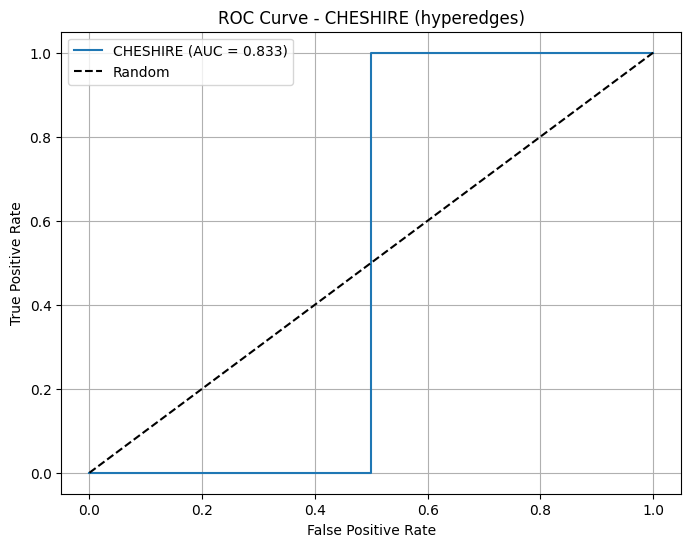


CHESHIRE RESULTS (Average of 3 simulations):
F1 Score: 0.6556
ROC-AUC: 0.8333
Precision: 0.5000
Recall: 1.0000
Accuracy: 0.6667
Log Loss: 0.6125
Matthews Coefficient: 0.4960


In [14]:
vertices = [f'v{i}' for i in range(100)]
hyperedge_names = [f'he{i}' for i in range(25)]

print('Example 4: Random Hypergraph')
random_hg = hypergraph_random_creator(vertices, hyperedge_names, 10, 3, 8)
results_random = run_cheshire_simulation(random_hg, 'hyperedges', 'vertices', K=3, max_epoch=30, plot_roc=True)

### Example 5: ChatGPT & LLMs Categories Hypergraph

Example 5: ChatGPT & LLMs Categories Hypergraph
Number of hyperedges = 1216
Number of vertices = 192
Incidence matrix shape = torch.Size([192, 1216])
Positive incidence matrix shape = torch.Size([192, 1216])
Created 5424.0 negative connections
Negative incidence matrix shape = torch.Size([192, 1216])
Labels shape = torch.Size([2432])
Final incidence matrix shape = torch.Size([192, 2432])

Running 3 simulations...
Simulation 1/3
  Epoch 0, Loss: 0.6930
  Epoch 10, Loss: 0.4899
  Epoch 20, Loss: 0.3752
  F1: 0.9186, ROC-AUC: 0.9756
Simulation 2/3
  Epoch 0, Loss: 0.6956
  Epoch 10, Loss: 0.5029
  Epoch 20, Loss: 0.3854
  F1: 0.8881, ROC-AUC: 0.9803
Simulation 3/3
  Epoch 0, Loss: 0.6939
  Epoch 10, Loss: 0.4817
  Epoch 20, Loss: 0.3761
  F1: 0.8969, ROC-AUC: 0.9536


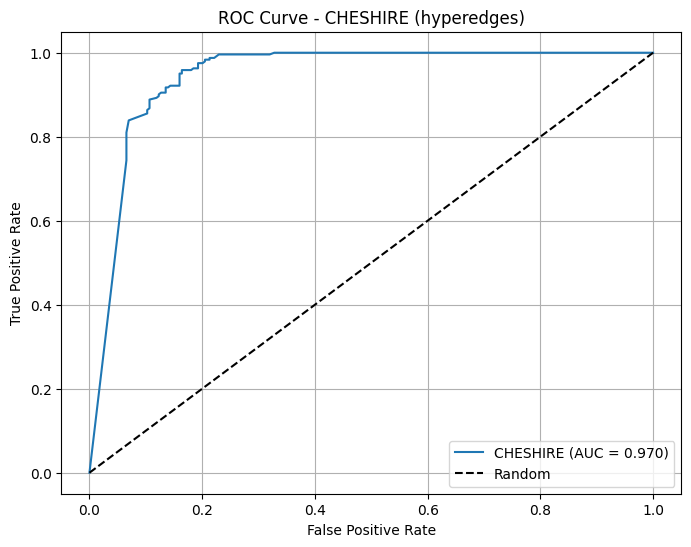


CHESHIRE RESULTS (Average of 3 simulations):
F1 Score: 0.9012
ROC-AUC: 0.9698
Precision: 0.8377
Recall: 0.9759
Accuracy: 0.8951
Log Loss: 0.3358
Matthews Coefficient: 0.8019


In [15]:
print('Example 5: ChatGPT & LLMs Categories Hypergraph')
with open('simplified_categories_hypergraph_d.pkl', 'rb') as f:
    categories_hg = pickle.load(f)
results_categories = run_cheshire_simulation(categories_hg, 'hyperedges', 'vertices', K=3, max_epoch=30, plot_roc=True)

## Comparison Tables

In [16]:
def create_complete_comparison_table_with_save(results_list, example_names, 
                                               method_name, task_name, 
                                               save_dir="results", 
                                               display_results=True):
    
    comparison_data = []
    
    for i, results in enumerate(results_list):
        hg_info = results['hypergraph_info']
        ml_scores = results['ml_scores']
        eval_scores = results['structural_evaluation']
        
        row = {
            'Hypergraph': example_names[i],
            'Nodes': hg_info['num_nodes'],
            'Hyperedges': hg_info['num_hyperedges'],
            'Avg HE Size': round(hg_info['avg_hyperedge_size'], 2),
            # The 7 ML Scores
            'F1 Score': round(ml_scores['f1'], 4),
            'Recall': round(ml_scores['recall'], 4),
            'Precision': round(ml_scores['precision'], 4),
            'Accuracy': round(ml_scores['accuracy'], 4),
            'ROC-AUC': round(ml_scores['roc_auc'], 4),
            'Log Loss': round(ml_scores['log_loss'], 4) if ml_scores['log_loss'] != float('inf') else 'inf',
            'Matthews Coeff': round(ml_scores['matthews_corrcoef'], 4),
            # Structural Scores
            'Predicted Connectivity': round(eval_scores['avg_predicted_internal_connectivity'], 4),
            'Random Connectivity': round(eval_scores['avg_random_baseline_connectivity'], 4),
            'Connectivity Ratio': round(eval_scores['connectivity_ratio'], 2),
            'Avg Node Degree (Overall)': round(eval_scores['avg_overall_node_degree'], 2),
            'Avg Node Degree (Predicted)': round(eval_scores['avg_node_degree_in_predictions'], 2)
        }
        comparison_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    
    # Save results for aggregation
    save_results_for_aggregation(df, method_name, task_name, save_dir)
    
    # Display results if requested (original functionality)
    if display_results:
        display_comparison_tables(df)
    
    return df

def save_results_for_aggregation(df, method_name, task_name, save_dir):
    """
    Save the comparison results in a structured format for later aggregation.
    """
    # Create directory structure
    method_dir = Path(save_dir) / method_name
    method_dir.mkdir(parents=True, exist_ok=True)
    
    # Prepare data for saving
    save_data = {
        'metadata': {
            'method': method_name,
            'task': task_name,
            'timestamp': datetime.now().isoformat(),
            'num_hypergraphs': len(df)
        },
        'results': df.to_dict('records')
    }
    
    # Save to JSON file
    filename = f"{task_name}_results.json"
    filepath = method_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(save_data, f, indent=2, default=str)
    
    print(f"✓ Results saved to: {filepath}")

def display_comparison_tables(df):
    """
    Display the comparison tables in the original format.
    """
    # Set pandas display options for better formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 4)

    # 1. ML SCORES COMPARISON TABLE (FIRST)
    print("\n" + "="*90)
    print("ML SCORES COMPARISON TABLE")
    print("="*90)
    ml_columns = ['Hypergraph', 'F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Log Loss', 'Matthews Coeff']
    ml_df = df[ml_columns]

    # Format ML table nicely
    print(f"{'Hypergraph':<20} {'F1':<8} {'Recall':<8} {'Precision':<10} {'Accuracy':<9} {'ROC-AUC':<8} {'Log Loss':<9} {'Matthews':<9}")
    print("-" * 90)
    for i, row in ml_df.iterrows():
        # Handle potential string values (like 'inf')
        log_loss_str = f"{row['Log Loss']:.4f}" if isinstance(row['Log Loss'], (int, float)) else str(row['Log Loss'])
        print(f"{row['Hypergraph']:<20} {row['F1 Score']:<8.4f} {row['Recall']:<8.4f} {row['Precision']:<10.4f} {row['Accuracy']:<9.4f} {row['ROC-AUC']:<8.4f} {log_loss_str:<9} {row['Matthews Coeff']:<9.4f}")
    print("="*90)

    # 2. STRUCTURAL SCORES COMPARISON TABLE
    print("\n\n" + "="*100)
    print("STRUCTURAL SCORES COMPARISON TABLE")
    print("="*100)

    structural_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'Avg HE Size', 'Predicted Connectivity', 
                         'Random Connectivity', 'Connectivity Ratio']
    structural_df = df[structural_columns]

    # Format structural table nicely
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<7} {'Avg Size':<9} {'Pred Conn':<10} {'Rand Conn':<10} {'Conn Ratio':<10}")
    print("-" * 100)
    for i, row in structural_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<7} {row['Avg HE Size']:<9.2f} {row['Predicted Connectivity']:<10.4f} {row['Random Connectivity']:<10.4f} {row['Connectivity Ratio']:<10.2f}")
    print("="*100)

    # 3. COMPLETE COMPARISON TABLE (SIMPLIFIED)
    print("\n\n" + "="*80)
    print("COMPLETE COMPARISON TABLE - SUMMARY")
    print("="*80)
    print("(Showing key metrics only for readability)")
    print("-"*80)
    summary_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'F1 Score', 'ROC-AUC', 'Connectivity Ratio']
    summary_df = df[summary_columns]
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<8} {'F1':<8} {'ROC-AUC':<8} {'Conn Ratio':<11}")
    print("-" * 80)
    for i, row in summary_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<8} {row['F1 Score']:<8.4f} {row['ROC-AUC']:<8.4f} {row['Connectivity Ratio']:<11.2f}")
    print("="*80)

example_names = ['Southern Women', 'Karate Club', 'Les Miserables', 'Random Hypergraph', 'Cat. Hypergraph']
results_list = [results_sw, results_karate, results_lesmiserables, results_random, results_categories]

comparison_df = create_complete_comparison_table_with_save(
    results_list=results_list,
    example_names=example_names,
    method_name='CHESHIRE',
    task_name='hypergraph_reconstruction',
    save_dir='results',
    display_results=True
)    

✓ Results saved to: results/CHESHIRE/hypergraph_reconstruction_results.json

ML SCORES COMPARISON TABLE
Hypergraph           F1       Recall   Precision  Accuracy  ROC-AUC  Log Loss  Matthews 
------------------------------------------------------------------------------------------
Southern Women       0.7778   0.8333   0.8333     0.8333    1.0000   0.4628    0.7182   
Karate Club          0.5640   0.5250   0.6250     0.6190    0.6542   0.8841    0.2136   
Les Miserables       0.6495   0.6652   0.6462     0.6522    0.6702   1.2359    0.3160   
Random Hypergraph    0.6556   1.0000   0.5000     0.6667    0.8333   0.6125    0.4960   
Cat. Hypergraph      0.9012   0.9759   0.8377     0.8951    0.9698   0.3358    0.8019   


STRUCTURAL SCORES COMPARISON TABLE
Hypergraph           Nodes  HEdges  Avg Size  Pred Conn  Rand Conn  Conn Ratio
----------------------------------------------------------------------------------------------------
Southern Women       18     14      9.29      1.0000  